<a href="https://colab.research.google.com/github/nithindsouza/Fraud-Tansaction-Detection/blob/main/FTD_Data_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Transaction data simulator
<h4>Transaction features</h4>

Our focus will be on the most essential features of a transaction. In essence, a payment card transaction consists of any amount paid to a merchant by a customer at a certain time. The six main features that summarise a transaction therefore are:

1. The transaction ID: A unique identifier for the transaction
2. The date and time: Date and time at which the transaction occurs
3. The customer ID: The identifier for the customer. Each customer has a unique identifier
4. The terminal ID: The identifier for the merchant (or more precisely the terminal). Each terminal has a unique identifier
5. The transaction amount: The amount of the transaction.
6. The fraud label: A binary variable, with the value $0$ for a legitimate transaction, or the value $1$ for a fraudulent transaction.

These features will be referred to as `TRANSACTION_ID`, `TX_DATETIME`, `CUSTOMER_ID`, `TERMINAL_ID`, `TX_AMOUNT`, and `TX_FRAUD`. 

The goal of the transaction data simulator will be to generate a table of transactions with these features.

<h4>Transaction generation process</h4>

The simulation will consist of five main steps:

1. **Generation of customer profiles:** Every customer is different in their spending habits. This will be simulated by defining some properties for each customer. The main properties will be their geographical location, their spending frequency, and their spending amounts. The customer properties will be represented as a table, referred to as the *customer profile table*. 
2. **Generation of terminal profiles:** Terminal properties will simply consist of a geographical location. The terminal properties will be represented as a table, referred to as the *terminal profile table*.
3. **Association of customer profiles to terminals:** We will assume that customers only make transactions on terminals that are within a radius of $r$ of their geographical locations. This makes the simple assumption that a customer only makes transactions on terminals that are geographically close to their location. This step will consist of adding a feature 'list_terminals' to each customer profile, that contains the set of terminals that a customer can use.
4. **Generation of transactions:** The simulator will loop over the set of customer profiles, and generate transactions according to their properties (spending frequencies and amounts, and available terminals). This will result in a table of transactions.
5. **Generation of fraud scenarios:** This last step will label the transactions as legitimate or genuine. This will be done by following three different fraud scenarios.

The following sections provide the implementation for each of these steps. 
    

In [1]:
# Necessary imports for this notebook
import os

import numpy as np
import pandas as pd

import datetime
import time

import random

# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})


## Customer profiles generation

Each customer will be defined by the following properties:

* `CUSTOMER_ID`: The customer unique ID
* (`x_customer_id`,`y_customer_id`): A pair of real coordinates (`x_customer_id`,`y_customer_id`) in a 100 * 100 grid, that defines the geographical location of the customer
* (`mean_amount`, `std_amount`):  The mean and standard deviation of the transaction amounts for the customer, assuming that the transaction amounts follow a normal distribution. The `mean_amount` will be drawn from a uniform distribution (5,100) and the `std_amount` will be set as the `mean_amount` divided by two. 
* `mean_nb_tx_per_day`:  The average number of transactions per day for the customer, assuming that the number of transactions per day follows a Poisson distribution. This number will be drawn from a uniform distribution (0,4). 

The `generate_customer_profiles_table` function provides an implementation for generating a table of customer profiles. It takes as input the number of customers for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each customer. 

In [2]:
def generate_customer_profiles_table(n_customers, random_state=0):
    
    np.random.seed(random_state)
        
    customer_id_properties=[]
    
    # Generate customer properties from random distributions 
    for customer_id in range(n_customers):
        
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_table

As an example, let us generate a customer profile table for five customers:

In [3]:
n_customers = 5
customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
customer_profiles_table

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day
0,0,54.881350,71.518937,62.262521,31.131260,2.179533
1,1,42.365480,64.589411,46.570785,23.285393,3.567092
2,2,96.366276,38.344152,80.213879,40.106939,2.115580
3,3,56.804456,92.559664,11.748426,5.874213,0.348517
4,4,2.021840,83.261985,78.924891,39.462446,3.480049


## Terminal profiles generation

Each terminal will be defined by the following properties:

* `TERMINAL_ID`: The terminal ID
* (`x_terminal_id`,`y_terminal_id`): A pair of real coordinates (`x_terminal_id`,`y_terminal_id`) in a 100 * 100 grid, that defines the geographical location of the terminal

The `generate_terminal_profiles_table` function provides an implementation for generating a table of terminal profiles. It takes as input the number of terminals for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each terminal. 


In [4]:
def generate_terminal_profiles_table(n_terminals, random_state=0):
    
    np.random.seed(random_state)
        
    terminal_id_properties=[]
    
    # Generate terminal properties from random distributions 
    for terminal_id in range(n_terminals):
        
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])
                                       
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                      'x_terminal_id', 'y_terminal_id'])
    
    return terminal_profiles_table

As an example, let us generate a customer terminal table for five terminals:

In [5]:
n_terminals = 5
terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 0)
terminal_profiles_table

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,54.881350,71.518937
1,1,60.276338,54.488318
2,2,42.365480,64.589411
3,3,43.758721,89.177300
4,4,96.366276,38.344152


## Association of customer profiles to terminals

Let us now associate terminals to customer profiles. In our design, customers can only perform transactions on terminals that are within a radius of `r` of their geographical locations. 

Let us first write a function, called `get_list_terminals_within_radius`, which finds these terminals for a customer profile. The function will take as input a customer profile (any row in the customer profiles table), an array that contains the geographical location of all terminals, and the radius `r`. It will return the list of terminals within a radius of `r` for that customer. 

In [6]:
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    
    # Use numpy arrays in the following to speed up computations
    
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])
    
    # Return the list of terminal IDs
    return available_terminals
    

As an example, let us get the list of terminals that are within a radius $r=50$ of the last customer:

In [7]:
# We first get the geographical locations of all terminals as a numpy array
x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
# And get the list of terminals within radius of $50$ for the last customer
get_list_terminals_within_radius(customer_profiles_table.iloc[4], x_y_terminals=x_y_terminals, r=50)

[2, 3]

The list contains the third and fourth terminals, which are indeed the only ones within a radius of $50$ of the last customer. 

In [8]:
terminal_profiles_table

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,54.881350,71.518937
1,1,60.276338,54.488318
2,2,42.365480,64.589411
3,3,43.758721,89.177300
4,4,96.366276,38.344152


For better visualization, let us plot 

* The locations of all terminals (in red)
* The location of the last customer (in blue)
* The region within radius of 50 of the first customer (in green)

In [9]:
%%capture

terminals_available_to_customer_fig, ax = plt.subplots(figsize=(5,5))

# Plot locations of terminals
ax.scatter(terminal_profiles_table.x_terminal_id.values, 
           terminal_profiles_table.y_terminal_id.values, 
           color='blue', label = 'Locations of terminals')

# Plot location of the last customer
customer_id=4
ax.scatter(customer_profiles_table.iloc[customer_id].x_customer_id, 
           customer_profiles_table.iloc[customer_id].y_customer_id, 
           color='red',label="Location of last customer")

ax.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1))

# Plot the region within a radius of 50 of the last customr
circ = plt.Circle((customer_profiles_table.iloc[customer_id].x_customer_id,
                   customer_profiles_table.iloc[customer_id].y_customer_id), radius=50, color='g', alpha=0.2)
ax.add_patch(circ)

fontsize=15

ax.set_title("Green circle: \n Terminals within a radius of 50 \n of the last customer")
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
    
ax.set_xlabel('x_terminal_id', fontsize=fontsize)
ax.set_ylabel('y_terminal_id', fontsize=fontsize)



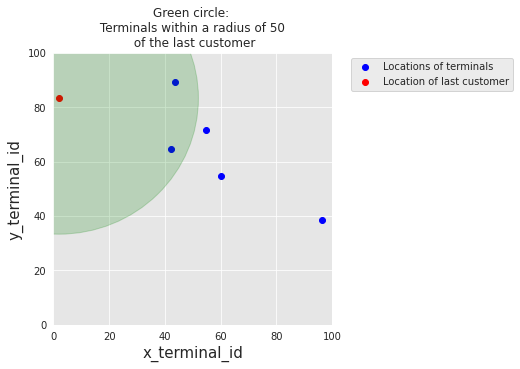

In [10]:
terminals_available_to_customer_fig

Computing the list of available terminals for each customer is then straightforward, using the panda `apply` function. We store the results as a new column `available_terminals` in the customer profiles table.

In [11]:
customer_profiles_table['available_terminals']=customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=50), axis=1)
customer_profiles_table

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[0, 1, 2, 3]"
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[0, 1, 2, 3]"
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[1, 4]"
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[0, 1, 2, 3]"
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[2, 3]"


It is worth noting that the radius $r$ controls the number of terminals that will be on average available for each customer. As the number of terminals is increased, this radius should be adapted to match the average number of available terminals per customer that is desired in a simulation.  

## Generation of transactions

The customer profiles now contain all the information that we require to generate transactions. The transaction generation will be done by a function `generate_transactions_table` that takes as input a customer profile, a starting date, and a number of days for which to generate transactions. It will return a table of transactions, which follows the format presented above (**without the transaction label**, which will be **added in** **Fraud_Scenarios_Generation**.


In [12]:
def generate_transactions_table(customer_profile, start_date = "2021-04-01", nb_days = 10):
    
    customer_transactions = []
    
    random.seed(customer_profile.CUSTOMER_ID)
    np.random.seed(customer_profile.CUSTOMER_ID)
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                    
                    if len(customer_profile.available_terminals)>0:
                        
                        terminal_id = random.choice(customer_profile.available_terminals)
                    
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, amount])
            
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions  
    
    

Let us for example generate transactions for the first customer, for five days, starting at the date 2021-04-01:

In [13]:
transaction_table_customer_0=generate_transactions_table(customer_profiles_table.iloc[0], 
                                                         start_date = "2021-04-01", 
                                                         nb_days = 5)
transaction_table_customer_0

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,2021-04-01 07:19:05,0,3,123.59,26345,0
1,2021-04-01 19:02:02,0,3,46.51,68522,0
2,2021-04-01 18:00:16,0,0,77.34,64816,0
3,2021-04-02 15:13:02,0,2,32.35,141182,1
4,2021-04-02 14:05:38,0,3,63.30,137138,1
5,2021-04-02 15:46:51,0,3,13.59,143211,1
6,2021-04-02 08:51:06,0,2,54.72,118266,1
7,2021-04-02 20:24:47,0,3,51.89,159887,1
8,2021-04-03 12:15:47,0,2,117.91,216947,2
9,2021-04-03 08:50:09,0,1,67.72,204609,2


We can make a quick check that the generated transactions follow the customer profile properties:

* The terminal IDs are indeed those in the list of available terminals (0, 1, 2 and 3)
* The transaction amounts seem to follow the amount parameters of the customer (`mean_amount`=62.26 and	`std_amount`=31.13)
* The number of transactions per day varies according to the transaction frequency parameters of the customer (`mean_nb_tx_per_day`=2.18).  


In [14]:
customer_profiles_table.iloc[0]

CUSTOMER_ID                       0
x_customer_id               54.8814
y_customer_id               71.5189
mean_amount                 62.2625
std_amount                  31.1313
mean_nb_tx_per_day          2.17953
available_terminals    [0, 1, 2, 3]
Name: 0, dtype: object

Let us now generate the transactions for all customers. This is straightforward using the pandas `groupby` and `apply` methods:

In [15]:
transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=5)).reset_index(drop=True)
transactions_df

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,2021-04-01 07:19:05,0,3,123.59,26345,0
1,2021-04-01 19:02:02,0,3,46.51,68522,0
2,2021-04-01 18:00:16,0,0,77.34,64816,0
3,2021-04-02 15:13:02,0,2,32.35,141182,1
4,2021-04-02 14:05:38,0,3,63.30,137138,1
...,...,...,...,...,...,...
60,2021-04-05 07:41:19,4,2,111.38,373279,4
61,2021-04-05 06:59:59,4,3,80.36,370799,4
62,2021-04-05 17:23:34,4,2,53.25,408214,4
63,2021-04-05 12:51:38,4,2,36.44,391898,4


This gives us a set of 65 transactions, with 5 customers, 5 terminals, and 5 days.

<h3> Scaling up to a larger dataset</h3>

We now have all the building blocks to generate a larger dataset. Let us write a `generate_dataset` function, that will take care of running all the previous steps. It will 

* take as inputs the number of desired customers, terminals and days, as well as the starting date and the radius `r`
* return the generated customer and terminal profiles table, and the DataFrame of transactions.

In [16]:
def generate_dataset(n_customers = 10000, n_terminals = 1000000, nb_days=90, start_date="2021-04-01", r=5):
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 1)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    # With Pandarallel
    #customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x : get_list_closest_terminals(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    # With Pandarallel
    #transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)
    

Let us generate a dataset that features 

* 5000 customers
* 10000 terminals
* 183 days of transactions (which corresponds to a simulated period from 2021/04/01 to 2021/09/30)

The starting date is arbitrarily fixed at 2021/04/01. The radius $r$ is set to 5, which corresponds to around 100 available terminals for each customer.

It takes around 3 minutes to generate this dataset on a standard laptop.

In [17]:
(customer_profiles_table, terminal_profiles_table, transactions_df)=\
    generate_dataset(n_customers = 5000, 
                     n_terminals = 10000, 
                     nb_days=183, 
                     start_date="2021-04-01", 
                     r=5)


Time to generate customer profiles table: 0.075s
Time to generate terminal profiles table: 0.066s
Time to associate terminals to customers: 3.9s
Time to generate transactions: 1.9e+02s


A total of 1754155 transactions were generated. 

In [18]:
transactions_df.shape

(1754155, 7)

Note that this number is low compared to real-world fraud detection systems, where millions of transactions may need to be processed every day. This will however be enough for the purpose of this book, in particular to keep reasonable executions times.

In [19]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,0,2021-04-01 00:00:31,596,3156,57.16,31,0
1,1,2021-04-01 00:02:10,4961,3412,81.51,130,0
2,2,2021-04-01 00:07:56,2,1365,146.00,476,0
3,3,2021-04-01 00:09:29,4128,8737,64.49,569,0
4,4,2021-04-01 00:10:34,927,9906,50.99,634,0
...,...,...,...,...,...,...,...
1754150,1754150,2021-09-30 23:56:36,161,655,54.24,15810996,182
1754151,1754151,2021-09-30 23:57:38,4342,6181,1.23,15811058,182
1754152,1754152,2021-09-30 23:58:21,618,1502,6.62,15811101,182
1754153,1754153,2021-09-30 23:59:52,4056,3067,55.40,15811192,182


As a sanity check, let us plot the distribution of transaction amounts and transaction times. 

In [20]:
%%capture

distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values

sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")


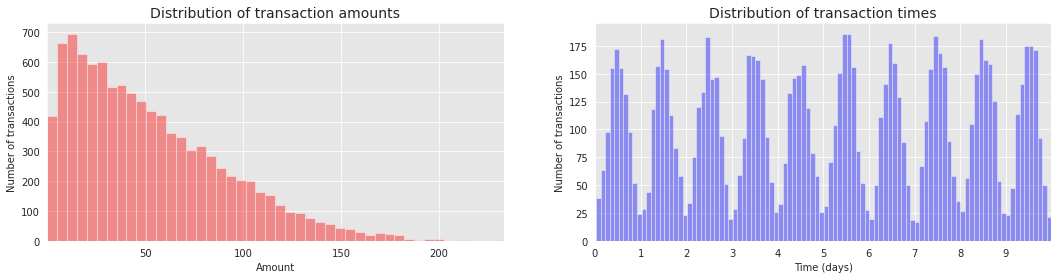

In [21]:
distribution_amount_times_fig

The distribution of transaction amounts has most of its mass for small amounts. The distribution of transaction times  follows a gaussian distribution on a daily basis, centered around noon. These two distributions are in accordance with the simulation parameters used in the previous sections.  

## Fraud scenarios generation

This last step of the simulation adds fraudulent transactions to the dataset, using the following fraud scenarios:

* Scenario 1: Any transaction whose amount is more than 220 is a fraud. This scenario is not inspired by a real-world scenario. Rather, it will provide an obvious fraud pattern that should be detected by any baseline fraud detector. This will be useful to validate the implementation of a fraud detection technique.  

* Scenario 2: Every day, a list of two terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. Detecting this scenario will be possible by adding features that keep track of the number of fraudulent transactions on the terminal. Since the terminal is only compromised for 28 days, additional strategies that involve concept drift will need to be designed to efficiently deal with this scenario.     

* Scenario 3: Every day, a list of 3 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. The customer continues to make transactions, and transactions of higher values are made by the fraudster who tries to maximize their gains. Detecting this scenario will require adding features that keep track of the spending habits of the customer. As for scenario 2, since the card is only temporarily compromised, additional strategies that involve concept drift should also be designed. 



In [22]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
    
    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+28) & 
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
                            
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+14) & 
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        nb_compromised_transactions=len(compromised_transactions)
        
        
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3
        
                             
    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    return transactions_df                 



Let us add fraudulent transactions using these scenarios:

In [23]:
%time transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

Number of frauds from scenario 1: 978
Number of frauds from scenario 2: 9099
Number of frauds from scenario 3: 4604
CPU times: user 1min 51s, sys: 668 ms, total: 1min 52s
Wall time: 1min 52s


Percentage of fraudulent transactions:

In [24]:
transactions_df.TX_FRAUD.mean()

0.008369271814634397

Number of fraudulent transactions:

In [25]:
transactions_df.TX_FRAUD.sum()

14681

A total of 14681 transactions were marked as fraudulent. This amounts to 0.8% of the transactions. Note that the sum of the frauds for each scenario does not equal the total amount of fraudulent transactions. This is because the same transactions may have been marked as fraudulent by two or more fraud scenarios.  

Our simulated transaction dataset is now complete, with a fraudulent label added to all transactions.

In [26]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2021-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2021-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2021-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2021-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2021-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [27]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==1].shape

(973, 9)

In [28]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==2].shape

(9077, 9)

In [29]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==3].shape

(4631, 9)

Let us check how the number of transactions, the number of fraudulent transactions, and the number of frauded cards vary on a daily basis. 

In [30]:
def get_stats(transactions_df):
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    return (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)

(nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)=get_stats(transactions_df)

n_days=len(nb_tx_per_day)
tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
tx_stats=tx_stats.reset_index()

In [31]:
%%capture

sns.set(style='darkgrid')
sns.set(font_scale=1.4)

fraud_and_transactions_stats_fig = plt.gcf()

fraud_and_transactions_stats_fig.set_size_inches(15, 8)

sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)

sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of frauded cards per day', fontsize=20)
sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")

sns_plot.set_ylim([0,300])

labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day", "# fraudulent cards per day"]

sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)



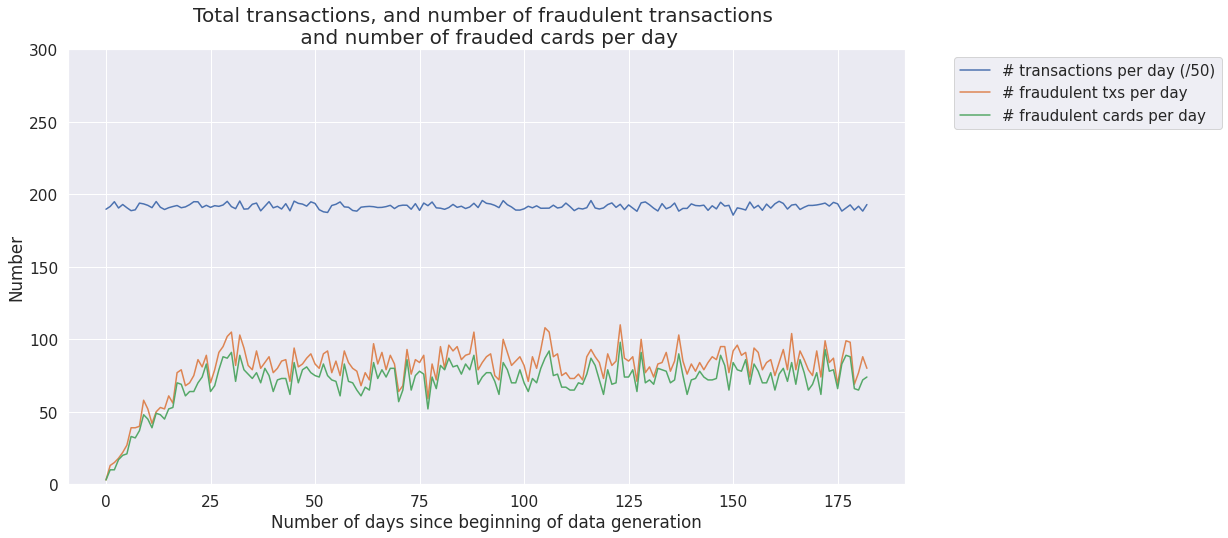

In [32]:
fraud_and_transactions_stats_fig

This simulation generated around 10000 transactions per day. The number of fraudulent transactions per day is around 85, and the number of fraudulent cards around 80. It is worth noting that the first month has a lower number of fraudulent transactions, which is due to the fact that frauds from scenarios 2 and 3 span periods of 28 and 14 days, respectively. 

The resulting dataset is interesting: It features class imbalance (less than 1% of fraudulent transactions), a mix of numerical and categorical features, non-trivial relationships between features, and time-dependent fraud scenarios.

Let us finally save the dataset for reuse in the rest of this book.

In [36]:
#writing df to a csv
transactions_df.columns= transactions_df.columns.str.lower()
transactions_df.to_csv("transactions_df.csv" , index = False)

The generated dataset is also available at Google Drive:[ transactions_df.csv](https://drive.google.com/file/d/15E9ZK3xQqYJT3z1pSBkXaVZNWi6q0T-i/view?usp=sharing)